In [31]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
def subsequent_mask(size: int, device=None):
    if device is None:
        device = torch.device('cpu')
    mask = torch.triu(torch.ones((size, size), device=device), diagonal=1).bool()
    float_mask = torch.zeros((1, 1, size, size), device=device)
    float_mask = float_mask.masked_fill(mask.unsqueeze(0).unsqueeze(0), float('-inf'))
    return float_mask

In [33]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout: float = 0.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    def forward(self, Q, K, V, mask=None):
        d_k = Q.size(-1)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores + mask
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        output = torch.matmul(attn, V)
        return output, attn

In [34]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim: int, dropout: float = 0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.attention = ScaledDotProductAttention(dropout)

    def forward(self, x, mask=None):
        Q = self.q_proj(x).unsqueeze(1)
        K = self.k_proj(x).unsqueeze(1)
        V = self.v_proj(x).unsqueeze(1)
        out, attn = self.attention(Q, K, V, mask=mask)
        out = out.squeeze(1)
        out = self.out_proj(out)
        return out, attn.squeeze(1)

In [35]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.0):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.d_k = embed_dim // num_heads
        self.q_linear = nn.Linear(embed_dim, embed_dim)
        self.k_linear = nn.Linear(embed_dim, embed_dim)
        self.v_linear = nn.Linear(embed_dim, embed_dim)
        self.out_linear = nn.Linear(embed_dim, embed_dim)
        self.attention = ScaledDotProductAttention(dropout)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()
        Q = self.q_linear(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.k_linear(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v_linear(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        out, attn = self.attention(Q, K, V, mask=mask)
        out = out.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
        out = self.out_linear(out)
        return out, attn

In [36]:
def visualize_attention(attn, title="Attention Matrix", head=0, example=0):
    attn_matrix = attn[example, head].detach().cpu().numpy()
    plt.figure(figsize=(6, 5))
    sns.heatmap(attn_matrix, cmap="viridis", annot=True, fmt=".2f")
    plt.title(f"{title} (Example {example}, Head {head})")
    plt.xlabel("Key Positions")
    plt.ylabel("Query Positions")
    plt.show()

SelfAttention out shape: torch.Size([2, 5, 16])
SelfAttention attn shape: torch.Size([2, 5, 5])


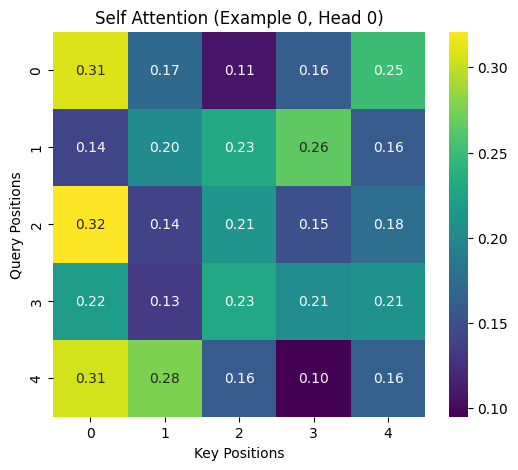

In [37]:
if __name__ == "__main__":
    torch.manual_seed(42)

    batch = 2
    seq_len = 5
    embed_dim = 16
    num_heads = 4

    x = torch.randn(batch, seq_len, embed_dim)
    sa = SelfAttention(embed_dim)
    out_sa, attn_sa = sa(x)
    print('SelfAttention out shape:', out_sa.shape)
    print('SelfAttention attn shape:', attn_sa.shape)

    visualize_attention(attn_sa.unsqueeze(1), title="Self Attention", head=0, example=0)



MultiHeadAttention out shape: torch.Size([2, 5, 16])
MultiHeadAttention attn shape: torch.Size([2, 4, 5, 5])


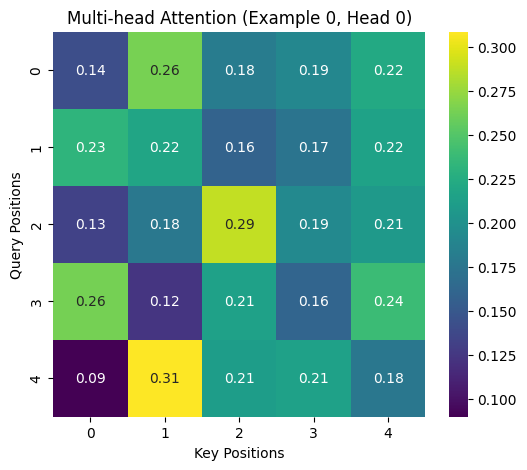

In [38]:
mha = MultiHeadAttention(embed_dim, num_heads)
out_mha, attn_mha = mha(x)
print('MultiHeadAttention out shape:', out_mha.shape)
print('MultiHeadAttention attn shape:', attn_mha.shape)
visualize_attention(attn_mha, title="Multi-head Attention", head=0, example=0)

Masked MultiHeadAttention out shape: torch.Size([2, 5, 16])
Masked attn (head 0) matrix:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5155, 0.4845, 0.0000, 0.0000, 0.0000],
        [0.2223, 0.2956, 0.4821, 0.0000, 0.0000],
        [0.3462, 0.1618, 0.2813, 0.2107, 0.0000],
        [0.0897, 0.3089, 0.2109, 0.2140, 0.1766]], grad_fn=<SelectBackward0>)


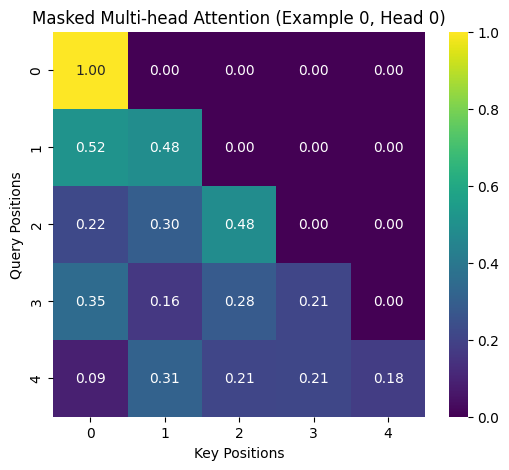

In [39]:
mask = subsequent_mask(seq_len, device=x.device)
out_masked, attn_masked = mha(x, mask=mask)
print('Masked MultiHeadAttention out shape:', out_masked.shape)
print('Masked attn (head 0) matrix:')
print(attn_masked[0, 0])
visualize_attention(attn_masked, title="Masked Multi-head Attention", head=0, example=0)

In [40]:

if __name__ == '__main__':
    torch.manual_seed(42)

    batch = 2
    seq_len = 5
    embed_dim = 16
    num_heads = 4

    x = torch.randn(batch, seq_len, embed_dim)

    # Single-head self-attention

    # Multi-head attention
    mha = MultiHeadAttention(embed_dim, num_heads)
    out_mha, attn_mha = mha(x)
    print('MultiHeadAttention out shape:', out_mha.shape)  # (batch, seq_len, embed_dim)
    print('MultiHeadAttention attn shape:', attn_mha.shape)  # (batch, heads, seq_len, seq_len)

    # Masked (causal) multi-head attention: create mask and apply
    mask = subsequent_mask(seq_len, device=x.device)  # (1,1,seq_len,seq_len)
    out_masked, attn_masked = mha(x, mask=mask)
    print('Masked MultiHeadAttention out shape:', out_masked.shape)
    print('Masked attn (head 0) matrix:')
    print(attn_masked[0, 0])

    # Quick checks: ensure masked attention has negligible attention to future positions
    # We'll test the first example in batch, first head.
    attn_sample = attn_masked[0, 0].detach()
    # For i < j (future positions), attention probability should be ~0
    future_values = attn_sample.triu(diagonal=1)
    print('Sum of attention to future positions (should be ~0):', float(future_values.sum()))

    # sanity: gradients flow
    out = out_mha.mean()
    out.backward()
    grads = [p.grad is not None for p in mha.parameters()]
    print('Gradients computed for parameters?', all(grads))

    # Example: using attention in a transformer-like residual block
    class SimpleTransformerBlock(nn.Module):
        def __init__(self, embed_dim, num_heads, ff_hidden=64, dropout=0.1):
            super().__init__()
            self.mha = MultiHeadAttention(embed_dim, num_heads, dropout=dropout)
            self.norm1 = nn.LayerNorm(embed_dim)
            self.ff = nn.Sequential(
                nn.Linear(embed_dim, ff_hidden),
                nn.ReLU(),
                nn.Linear(ff_hidden, embed_dim),
            )
            self.norm2 = nn.LayerNorm(embed_dim)

        def forward(self, x, mask=None):
            attn_out, _ = self.mha(x, mask=mask)
            x = self.norm1(x + attn_out)
            ff_out = self.ff(x)
            x = self.norm2(x + ff_out)
            return x

    block = SimpleTransformerBlock(embed_dim, num_heads)
    sample_out = block(x, mask=mask)
    print('Transformer block output shape:', sample_out.shape)

    print('All tests ran successfully.')


MultiHeadAttention out shape: torch.Size([2, 5, 16])
MultiHeadAttention attn shape: torch.Size([2, 4, 5, 5])
Masked MultiHeadAttention out shape: torch.Size([2, 5, 16])
Masked attn (head 0) matrix:
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5151, 0.4849, 0.0000, 0.0000, 0.0000],
        [0.4332, 0.1882, 0.3785, 0.0000, 0.0000],
        [0.3184, 0.1412, 0.3086, 0.2319, 0.0000],
        [0.1261, 0.4621, 0.1121, 0.1493, 0.1504]], grad_fn=<SelectBackward0>)
Sum of attention to future positions (should be ~0): 0.0
Gradients computed for parameters? True
Transformer block output shape: torch.Size([2, 5, 16])
All tests ran successfully.
